# Generative Adverserial Networks

GANs are a framework for teaching a DL model to capture the training data’s distribution so we can generate new data from that same distribution.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense,Reshape,Dropout,LeakyReLU,Flatten,BatchNormalization,Conv2D,Conv2DTranspose
from tensorflow.keras.models import Sequential

2023-03-26 21:07:08.863801: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
SEED = 42
INPUT_SHAPE = 100
BATCH_SIZE = 32
EPOCHS = 25

## Dataset

Using a GAN to generate "fake" MNIST digit images.

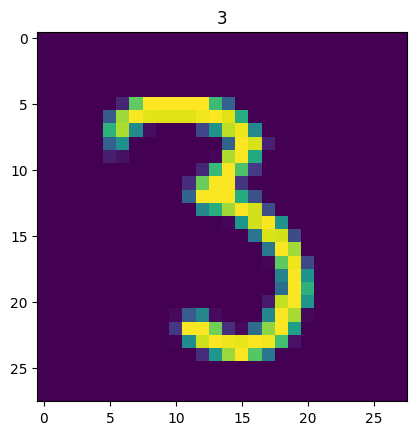

In [3]:
# setting up the dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

plt.imshow(X_train[8888])
plt.title(y_train[8888])
plt.show()

![Generative Adverserial Networks](../assets/05_Tensorflow_Unsupervised_Learning_19.png)

In [4]:
# to speed up the training we can pre-select
# only images with label `3`
X_train_three = X_train[y_train==3]
print(X_train_three.shape)
# there are 6131 images that represent the digit 3
# (6131, 28, 28)

(6131, 28, 28)


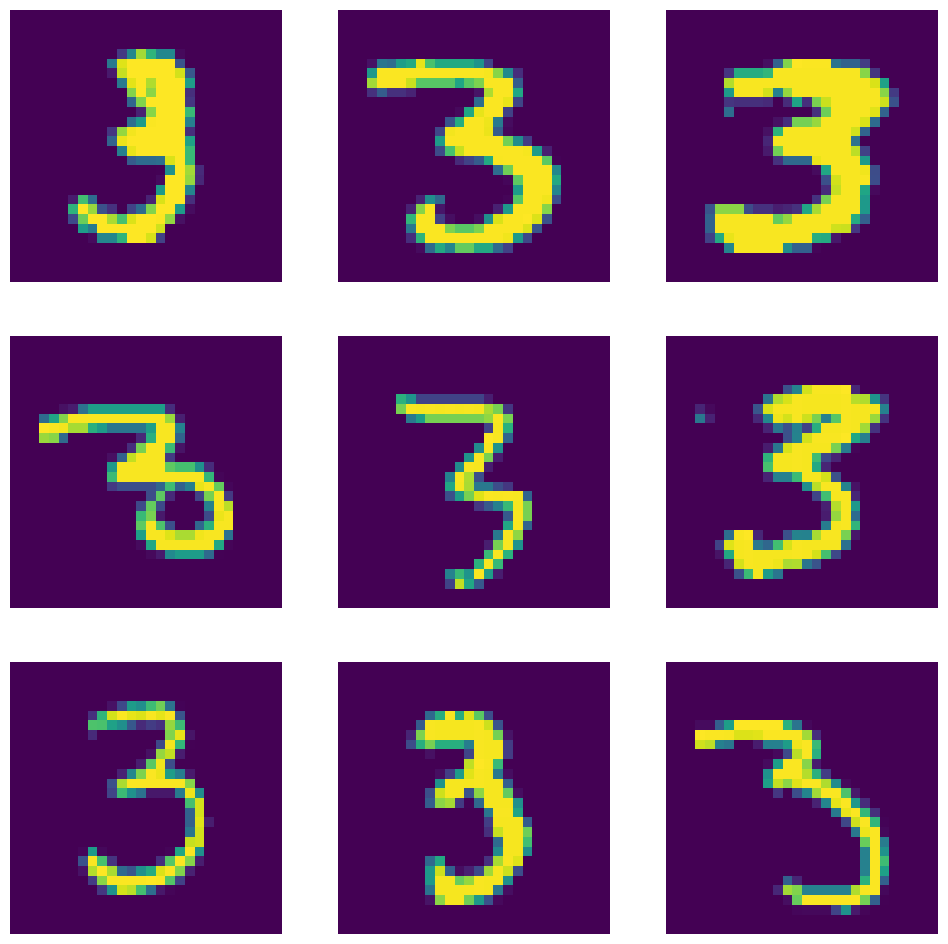

In [5]:
# plot results
plt.figure(figsize=(12, 12))
# ROW 1
plt.subplot(3, 3, 1)
plt.axis(False)
plt.imshow(X_train_three[1])
plt.subplot(3, 3, 2)
plt.axis(False)
plt.imshow(X_train_three[2])
plt.subplot(3, 3, 3)
plt.axis(False)
plt.imshow(X_train_three[3])
# ROW 2
plt.subplot(3, 3, 4)
plt.axis(False)
plt.imshow(X_train_three[4])
plt.subplot(3, 3, 5)
plt.axis(False)
plt.imshow(X_train_three[5])
plt.subplot(3, 3, 6)
plt.axis(False)
plt.imshow(X_train_three[6])
# ROW 3
plt.subplot(3, 3, 7)
plt.axis(False)
plt.imshow(X_train_three[7])
plt.subplot(3, 3, 8)
plt.axis(False)
plt.imshow(X_train_three[8])
plt.subplot(3, 3, 9)
plt.axis(False)
plt.imshow(X_train_three[9])

![Generative Adverserial Networks](../assets/05_Tensorflow_Unsupervised_Learning_20.png)

### Create Batched Dataset

In [7]:
dataset = tf.data.Dataset.from_tensor_slices(X_train_three).shuffle(buffer_size=1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

## Building the Model

### Generator

In [8]:
tf.random.set_seed(SEED)

generator = Sequential(name="generator")
generator.add(Dense(100, activation="relu", input_shape=[INPUT_SHAPE]))
generator.add(Dense(150,activation='relu'))
generator.add(Dense(784, activation="sigmoid")) # 28*28 = 784
generator.add(Reshape([28,28]))

### Discriminator

In [9]:
discriminator = Sequential(name="discriminator")
discriminator.add(Flatten(input_shape=[28,28]))
discriminator.add(Dense(150,activation='relu'))
discriminator.add(Dense(100,activation='relu'))
discriminator.add(Dense(1,activation="sigmoid"))

discriminator.compile(loss="binary_crossentropy", optimizer="adam")
discriminator.trainable = False

In [10]:
GAN = Sequential([generator, discriminator])

GAN.compile(loss="binary_crossentropy", optimizer="adam")

GAN.summary()

# Model: "sequential"
# _________________________________________________________________
#  Layer (type)                Output Shape              Param #   
# =================================================================
#  generator (Sequential)      (None, 28, 28)            143634    
                                                                 
#  discriminator (Sequential)  (None, 1)                 132951    
                                                                 
# =================================================================
# Total params: 276,585
# Trainable params: 143,634
# Non-trainable params: 132,951
# _________________________________________________________________

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator (Sequential)      (None, 28, 28)            143634    
                                                                 
 discriminator (Sequential)  (None, 1)                 132951    
                                                                 
Total params: 276,585
Trainable params: 143,634
Non-trainable params: 132,951
_________________________________________________________________


## Training the Model

In [11]:
# Grab the seprate components
generator, discriminator = GAN.layers

# For every epcoh
for epoch in range(EPOCHS):
    print(f"INFO :: Epoch: {epoch+1}")
    i = 0
    # For every batch in the dataset
    for X_batch in dataset:
        i=i+1
        if i%100 == 0:
            print(f"\tBatch number: {i} of {len(X_train_three)//BATCH_SIZE}")
        #####################################
        ## TRAINING THE DISCRIMINATOR ######
        ###################################
        
        # Create Noise
        noise = tf.random.normal(shape=[BATCH_SIZE, INPUT_SHAPE])
        
        # Generate numbers based just on noise input
        gen_images = generator(noise)
        
        # Concatenate Generated Images against the Real Ones
        # TO use tf.concat, the data types must match!
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch,tf.float32)], axis=0)
        
        # Targets set to zero for fake images and 1 for real images
        y1 = tf.constant([[0.]] * BATCH_SIZE + [[1.]] * BATCH_SIZE)
        
        # This gets rid of a Keras warning
        discriminator.trainable = True
        
        # Train the discriminator on this batch
        discriminator.train_on_batch(X_fake_vs_real, y1)
        
        
        #####################################
        ## TRAINING THE GENERATOR     ######
        ###################################
        
        # Create some noise
        noise = tf.random.normal(shape=[BATCH_SIZE, INPUT_SHAPE])
        
        # We want discriminator to belive that fake images are real
        y2 = tf.constant([[1.]] * BATCH_SIZE)
        
        # Avois a warning
        discriminator.trainable = False
        
        GAN.train_on_batch(noise, y2)
        
print("INFO :: Training Completed")

INFO :: Epoch: 1


2023-03-26 21:13:21.880478: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f364c03e050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-26 21:13:21.880503: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2023-03-26 21:13:21.898408: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-26 21:13:21.901946: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-03-26 21:13:22.179513: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


	INFO :: Batch number: 100 of 191
INFO :: Epoch: 2
	INFO :: Batch number: 100 of 191
INFO :: Epoch: 3
	INFO :: Batch number: 100 of 191
INFO :: Epoch: 4
	INFO :: Batch number: 100 of 191
INFO :: Epoch: 5
	INFO :: Batch number: 100 of 191
INFO :: Epoch: 6
	INFO :: Batch number: 100 of 191
INFO :: Epoch: 7
	INFO :: Batch number: 100 of 191
INFO :: Epoch: 8
	INFO :: Batch number: 100 of 191
INFO :: Epoch: 9
	INFO :: Batch number: 100 of 191
INFO :: Epoch: 10
	INFO :: Batch number: 100 of 191
INFO :: Epoch: 11
	INFO :: Batch number: 100 of 191
INFO :: Epoch: 12
	INFO :: Batch number: 100 of 191
INFO :: Epoch: 13
	INFO :: Batch number: 100 of 191
INFO :: Epoch: 14
	INFO :: Batch number: 100 of 191
INFO :: Epoch: 15
	INFO :: Batch number: 100 of 191
INFO :: Epoch: 16
	INFO :: Batch number: 100 of 191
INFO :: Epoch: 17
	INFO :: Batch number: 100 of 191
INFO :: Epoch: 18
	INFO :: Batch number: 100 of 191
INFO :: Epoch: 19
	INFO :: Batch number: 100 of 191
INFO :: Epoch: 20
	INFO :: Batch numbe

## Making Predictions

The Generator expects a noise input tensor with input shape = INPUT_SHAPE. To have the Generator create an image - based on the previous training - we have to input such tensor of beautiful randomness.

(10, 100)


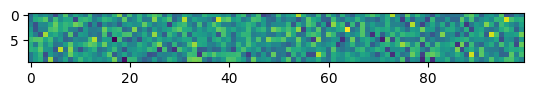

In [12]:
# generate noise for 10 images
noise_input = tf.random.normal(shape=[10, INPUT_SHAPE])

print(noise_input.shape)
# (10, 100)
plt.imshow(noise_input)

![Generative Adverserial Networks](../assets/05_Tensorflow_Unsupervised_Learning_21.png)

In [15]:
generated_images = generator(noise_input)
generated_images.shape
# TensorShape([10, 28, 28])

TensorShape([10, 28, 28])

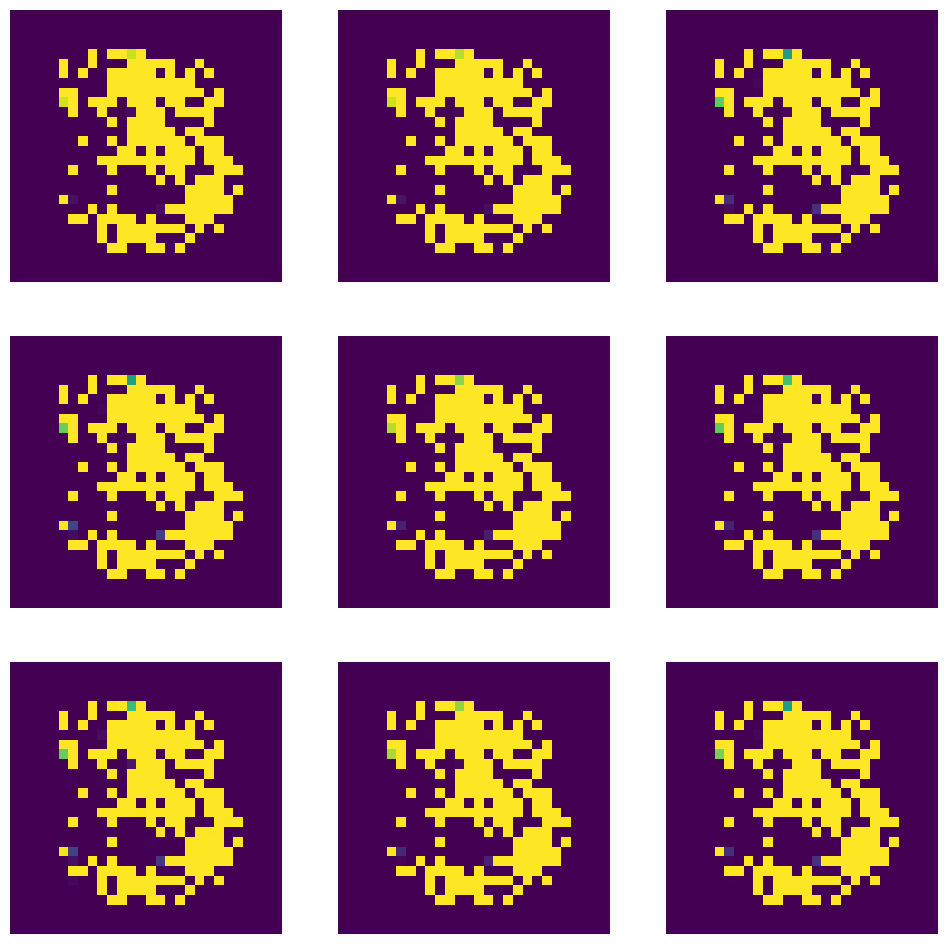

In [16]:
# plot results
plt.figure(figsize=(12, 12))
# ROW 1
plt.subplot(3, 3, 1)
plt.axis(False)
plt.imshow(generated_images[0])
plt.subplot(3, 3, 2)
plt.axis(False)
plt.imshow(generated_images[1])
plt.subplot(3, 3, 3)
plt.axis(False)
plt.imshow(generated_images[2])
# ROW 2
plt.subplot(3, 3, 4)
plt.axis(False)
plt.imshow(generated_images[3])
plt.subplot(3, 3, 5)
plt.axis(False)
plt.imshow(generated_images[4])
plt.subplot(3, 3, 6)
plt.axis(False)
plt.imshow(generated_images[5])
# ROW 3
plt.subplot(3, 3, 7)
plt.axis(False)
plt.imshow(generated_images[6])
plt.subplot(3, 3, 8)
plt.axis(False)
plt.imshow(generated_images[7])
plt.subplot(3, 3, 9)
plt.axis(False)
plt.imshow(generated_images[8])

![Generative Adverserial Networks](../assets/05_Tensorflow_Unsupervised_Learning_22.png)

Why do all generated `3`'s look the same? => [Combating Mode Collapse in GAN training: An Empirical Analysis using Hessian Eigenvalues](https://arxiv.org/abs/2012.09673)

# Deep Convolutional Generative Adversarial Networks (DCGAN)

A DCGAN is a direct extension of the GAN described above, except that it explicitly uses convolutional and convolutional-transpose layers in the discriminator and generator, respectively. It was first described by Radford et. al. in the paper [Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf).


The __Discriminator__ is made up of strided convolution layers, batch norm layers, and LeakyReLU activations. The input is a 3x64x64 input image and the output is a scalar probability that the input is from the real data distribution.


The __Generator__ is comprised of convolutional-transpose layers, batch norm layers, and ReLU activations. The input is a latent vector, \(z\), that is drawn from a standard normal distribution and the output is a 3x64x64 RGB image. The strided conv-transpose layers allow the latent vector to be transformed into a volume with the same shape as an image.

## Dataset

In [18]:
# Generator will use tanh activation function for the last layer,
# so we want to reshape X_train to be within -1 to 1 limits
X_train_norm = X_train/255
X_train_reshaped = X_train_norm.reshape(-1, 28, 28, 1) * 2. - 1.

print(X_train_norm.shape, X_train_reshaped.shape, X_train_reshaped.min(), X_train_reshaped.max())

(60000, 28, 28) (60000, 28, 28, 1) -1.0 1.0


In [19]:
# only images with label `3`
X_train_three_dcgan = X_train_reshaped[y_train==3]
print(X_train_three_dcgan.shape)
# (6131, 28, 28, 1)

(6131, 28, 28, 1)


### Create Batched Dataset

In [26]:
dataset = tf.data.Dataset.from_tensor_slices(X_train_three_dcgan).shuffle(buffer_size=1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

## Building the Model

### Generator

In [20]:
tf.random.set_seed(SEED)

generator = Sequential()
generator.add(Dense(7 * 7 * 128, input_shape=[INPUT_SHAPE]))
generator.add(Reshape([7, 7, 128]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same",
                                 activation="relu"))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding="same",
                                 activation="tanh"))

### Discriminator

In [22]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3),
                        input_shape=[28, 28, 1]))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

discriminator.compile(loss="binary_crossentropy", optimizer="adam")
discriminator.trainable = False

In [23]:
GAN = Sequential([generator, discriminator])
GAN.compile(loss="binary_crossentropy", optimizer="adam")
GAN.summary()

# Model: "sequential_4"
# _________________________________________________________________
#  Layer (type)                Output Shape              Param #   
# =================================================================
#  sequential_1 (Sequential)   (None, 28, 28, 1)         840705    
                                                                 
#  sequential_3 (Sequential)   (None, 1)                 212865    
                                                                 
# =================================================================
# Total params: 1,053,570
# Trainable params: 840,321
# Non-trainable params: 213,249
# _________________________________________________________________

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 28, 28, 1)         840705    
                                                                 
 sequential_3 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,053,570
Trainable params: 840,321
Non-trainable params: 213,249
_________________________________________________________________


## Model Training

In [28]:
# Grab the seprate components
generator, discriminator = GAN.layers

# For every epcoh
for epoch in range(EPOCHS):
    print(f"INFO :: Epoch: {epoch+1}")
    i = 0
    # For every batch in the dataset
    for X_batch in dataset:
        i=i+1
        if i%20 == 0:
            print(f"\tBatch number: {i} of {len(X_train_three)//BATCH_SIZE}")
        #####################################
        ## TRAINING THE DISCRIMINATOR ######
        ###################################
        
        # Create Noise
        noise = tf.random.normal(shape=[BATCH_SIZE, INPUT_SHAPE])
        
        # Generate numbers based just on noise input
        gen_images = generator(noise)
        
        # Concatenate Generated Images against the Real Ones
        # TO use tf.concat, the data types must match!
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch,tf.float32)], axis=0)
        
        # Targets set to zero for fake images and 1 for real images
        y1 = tf.constant([[0.]] * BATCH_SIZE + [[1.]] * BATCH_SIZE)
        
        # This gets rid of a Keras warning
        discriminator.trainable = True
        
        # Train the discriminator on this batch
        discriminator.train_on_batch(X_fake_vs_real, y1)
        
        
        #####################################
        ## TRAINING THE GENERATOR     ######
        ###################################
        
        # Create some noise
        noise = tf.random.normal(shape=[BATCH_SIZE, INPUT_SHAPE])
        
        # We want discriminator to belive that fake images are real
        y2 = tf.constant([[1.]] * BATCH_SIZE)
        
        # Avois a warning
        discriminator.trainable = False
        
        GAN.train_on_batch(noise, y2)
        
print("TRAINING COMPLETE")            

INFO :: Epoch: 1


2023-03-26 21:45:50.375077: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/sequential_3/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


	Batch number: 20 of 191
	Batch number: 40 of 191
	Batch number: 60 of 191
	Batch number: 80 of 191
	Batch number: 100 of 191
	Batch number: 120 of 191
	Batch number: 140 of 191
	Batch number: 160 of 191
	Batch number: 180 of 191
INFO :: Epoch: 2
	Batch number: 20 of 191
	Batch number: 40 of 191
	Batch number: 60 of 191
	Batch number: 80 of 191
	Batch number: 100 of 191
	Batch number: 120 of 191
	Batch number: 140 of 191
	Batch number: 160 of 191
	Batch number: 180 of 191
INFO :: Epoch: 3
	Batch number: 20 of 191
	Batch number: 40 of 191
	Batch number: 60 of 191
	Batch number: 80 of 191
	Batch number: 100 of 191
	Batch number: 120 of 191
	Batch number: 140 of 191
	Batch number: 160 of 191
	Batch number: 180 of 191
INFO :: Epoch: 4
	Batch number: 20 of 191
	Batch number: 40 of 191
	Batch number: 60 of 191
	Batch number: 80 of 191
	Batch number: 100 of 191
	Batch number: 120 of 191
	Batch number: 140 of 191
	Batch number: 160 of 191
	Batch number: 180 of 191
INFO :: Epoch: 5
	Batch numbe

## Making Predictions

The Generator expects a noise input tensor with input shape = INPUT_SHAPE. To have the Generator create an image - based on the previous training - we have to input such tensor of beautiful randomness.

(10, 100)


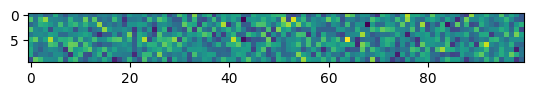

In [29]:
# generate noise for 10 images
noise_input = tf.random.normal(shape=[10, INPUT_SHAPE])

print(noise_input.shape)
# (10, 100)

In [30]:
generated_images = generator(noise_input)
generated_images.shape
# TensorShape([10, 28, 28])

TensorShape([10, 28, 28, 1])

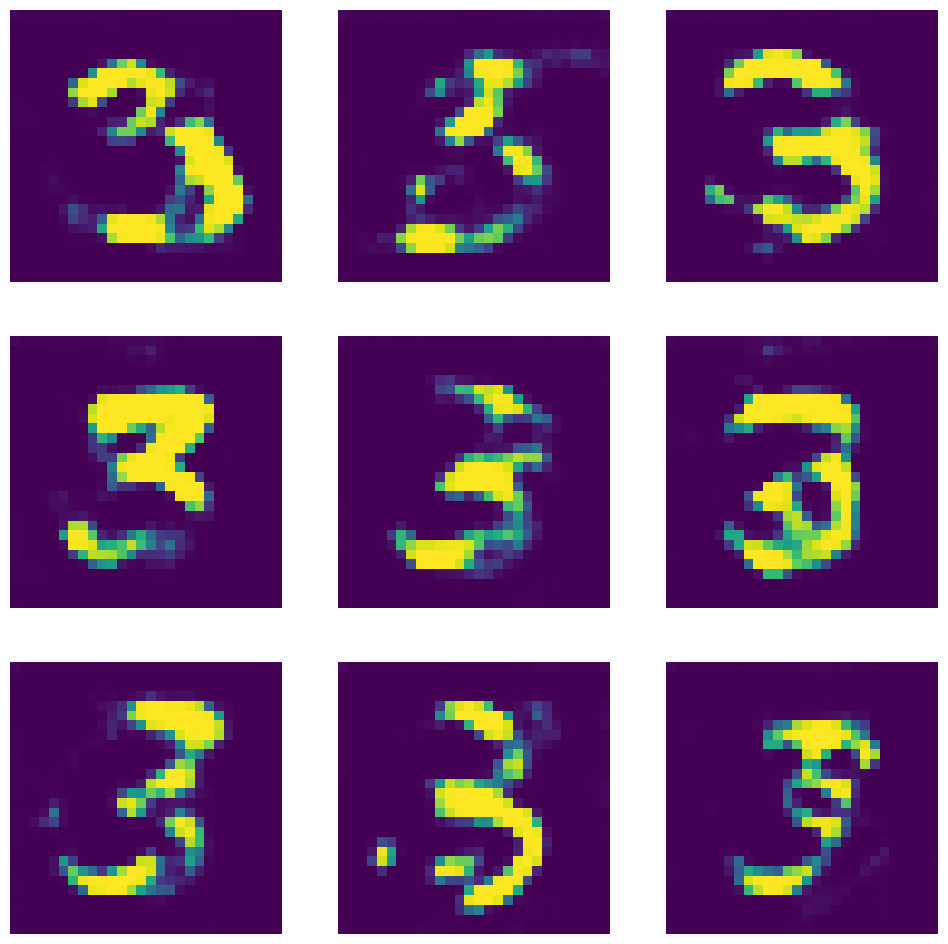

In [31]:
# plot results
plt.figure(figsize=(12, 12))
# ROW 1
plt.subplot(3, 3, 1)
plt.axis(False)
plt.imshow(generated_images[0])
plt.subplot(3, 3, 2)
plt.axis(False)
plt.imshow(generated_images[1])
plt.subplot(3, 3, 3)
plt.axis(False)
plt.imshow(generated_images[2])
# ROW 2
plt.subplot(3, 3, 4)
plt.axis(False)
plt.imshow(generated_images[3])
plt.subplot(3, 3, 5)
plt.axis(False)
plt.imshow(generated_images[4])
plt.subplot(3, 3, 6)
plt.axis(False)
plt.imshow(generated_images[5])
# ROW 3
plt.subplot(3, 3, 7)
plt.axis(False)
plt.imshow(generated_images[6])
plt.subplot(3, 3, 8)
plt.axis(False)
plt.imshow(generated_images[7])
plt.subplot(3, 3, 9)
plt.axis(False)
plt.imshow(generated_images[8])

![Generative Adverserial Networks](../assets/05_Tensorflow_Unsupervised_Learning_23.png)